# Lane Boundary Segmentation

## Setting up Colab

You can delete this "Setting up Colab" section if you work locally and do not want to use Google Colab

In [1]:
colab_nb = 'google.colab' in str(get_ipython())

In [2]:
if colab_nb:
  from google.colab import drive
  drive.mount('/content/drive')

In [3]:
if colab_nb:
  %cd drive/My\ Drive/aad/code/exercises/lane_detection

In [4]:
if colab_nb:
  !pip install segmentation-models-pytorch
  !pip install albumentations --upgrade

## Loading data

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
import sys
sys.path.append("../../util")

If you have collected data yourself in a folder "data" using `collect_data.py` and you want to use it for training, set the boolean in the next cell to `True`

In [6]:
own_data = False

In [7]:
if own_data:
    from seg_data_util import sort_collected_data
    # copy and sort content of 'data' into 'data_lane_segmentation' folder:
    sort_collected_data()
    # Since data was copied, you can remove files in 'data' directory afterwards
else:
    # if you stopped the download before completion, please delete the 'data_lane_segmentation' folder and run this cell again
    from seg_data_util import download_segmentation_data
    download_segmentation_data()

You already have a folder 'data_lane_segmentation'. No download necessary.
If you want to enforce the download, delete the folder 'data_lane_segmentation' and run this cell again.


Independent of what you chose, you will have a directory 'data_lane_segmentation' now

In [8]:
DATA_DIR = "data_lane_segmentation"

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_label')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')

Note that the labels are regular png images with 3 color channels. The content of those color channels is identical, so when you load the png you should just load the first color channel.

Your code starts here: Train a deep learning segmentation model and evaluate its dice loss on the validation set. You should aim for a dice loss of 0.2 or less!

In [9]:
# some other usefuls libs
import os
import matplotlib.pyplot as plt
import cv2
def get_image_array_from_fn(fn):
    image = cv2.imread(fn)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [10]:
from sys import platform
folder_token = "\\" if platform == "win32" else "/"

In [11]:
# function that takes filename of a training image 'fn' and returns the filename of the corresponding label image
def label_func(fn): 
    return str(fn).replace(".png", "_label.png").replace("train", "train_label").replace("val"+folder_token, "val_label"+folder_token)

data_lane_segmentation\val\Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set.png


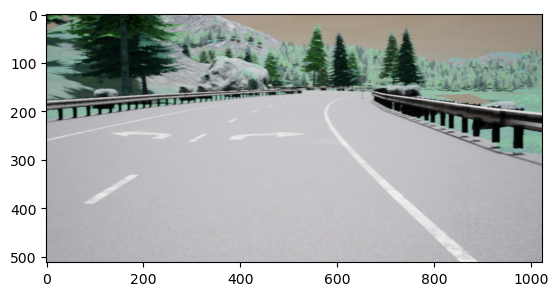

In [12]:
# pick the first image from the training directory and show it
sample_fn = os.path.join(x_valid_dir, os.listdir(x_valid_dir)[0])
print(sample_fn)
plt.imshow(get_image_array_from_fn(sample_fn));

data_lane_segmentation\val_label\Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set_label.png


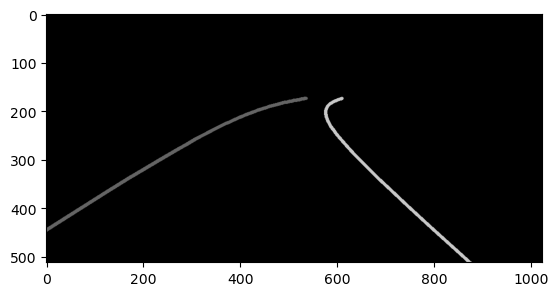

In [13]:
# get corresponding label image using our 'label_func' function
label_fn = label_func(sample_fn)
print(label_fn)
# we multiply the image intensity by 100 to make lane lines visible for the human eye:
plt.imshow(100*get_image_array_from_fn(label_fn)); 

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as albu
import torch.nn.functional as fun
import torch

class SegmentationDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        train_path = os.path.join(self.img_path, self.X[idx])
        label_path = label_func(train_path)
        img = cv2.imread(train_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(label_path, 0)
        
        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        t = transforms.Compose([transforms.ToTensor()]) # transforms.Normalize(self.mean, self.std)
        img = t(img)
        mask = torch.from_numpy(mask).long()
        mask = fun.one_hot(mask, num_classes=3).permute(2, 0, 1).double()
        
        return img, mask

In [15]:
train_transform = albu.Compose([
    albu.ShiftScaleRotate(
            scale_limit=0.2,
            rotate_limit=0,
            shift_limit=0.2,
            p=0.5,
            border_mode=0
        )
])

X_train = os.listdir(x_train_dir)
X_val = os.listdir(x_valid_dir)
train_set = SegmentationDataset(x_train_dir, y_train_dir, X_train, train_transform)
val_set = SegmentationDataset(x_valid_dir, y_valid_dir, X_val)


In [16]:
learning_rate = 1e-3
batch_size = 3
epochs = 10

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True) 

In [17]:
from pathlib import Path
sys.path.append(str(Path('../../')))
from exercises.lane_detection.unet import UNet
import torch

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

model = UNet().to(device)

In [19]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(10):  # loop over the dataset multiple times
    
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()*inputs.size(0)

        if i % 100 == 99:
            print("training loss for batch", i, ":", train_loss / 100)
            train_loss = 0.0
    
    else:
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()*inputs.size(0)
    
    print("validation loss for epoch", epoch, ":", valid_loss / len(val_set))


print('Finished Training')

training loss for batch 99 : 0.28931084443806865
training loss for batch 199 : 0.11555206446319588
training loss for batch 299 : 0.08634883126553429
training loss for batch 399 : 0.07993201379661365
training loss for batch 499 : 0.0673240887465029
training loss for batch 599 : 0.06428782168392001
training loss for batch 699 : 0.05871795580221786
training loss for batch 799 : 0.055312576937922
training loss for batch 899 : 0.057877248075211093
training loss for batch 999 : 0.0520983749215447
validation loss for epoch 0 : 0.020275370917785633
training loss for batch 99 : 0.049527643752091975
training loss for batch 199 : 0.04913402223687999
training loss for batch 299 : 0.04464486922521038
training loss for batch 399 : 0.04691520393569179
training loss for batch 499 : 0.04656735974997131
training loss for batch 599 : 0.042558719361445584
training loss for batch 699 : 0.04365871639246351
training loss for batch 799 : 0.04079141439706527
training loss for batch 899 : 0.04060190301552832
tr

In [20]:
torch.save(model.state_dict(), 'model_sd.pt')
torch.save(model, 'model.pt')

In [23]:
unet = UNet().to(device)
unet.load_state_dict(torch.load('model.pt'))
unet.eval()  

UNet(
  (double_conv): double_conv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encode1): encode(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [48]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow2(img):
    plt.imshow(img)
    plt.show()

dataiter = iter(val_loader)
images, labels = next(dataiter)


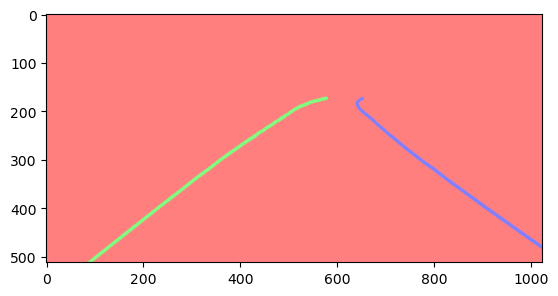

torch.Size([512, 1024, 3])


In [49]:
# show images
imshow(torchvision.utils.make_grid(labels[0]))
print(labels[0].permute(1,2,0).shape)

torch.Size([3, 3, 512, 1024])
torch.float32
max -43.31024
(3, 512, 1024)
float32


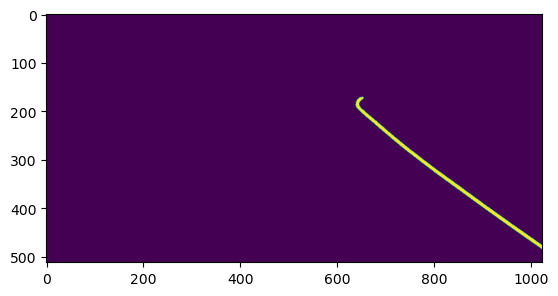

-43.31024


In [52]:
with torch.no_grad():
     
    pred = unet(images.to(device))
    print(pred.shape)
    print(pred[0].dtype)
    pred = pred.detach().cpu().numpy()
    print("max", np.min(pred))
    
    print(pred[0].shape)
    print(pred[0].dtype)
    plt.imshow(pred[0][2] > 1)
    plt.show()
    print(np.min(pred))

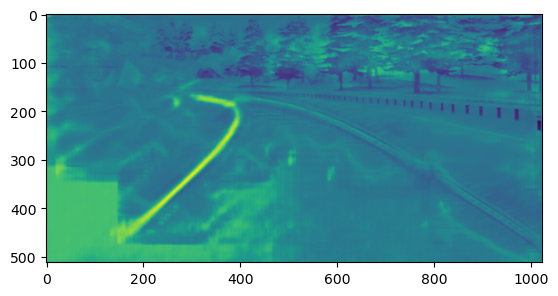

In [27]:
plt.imshow(pred[0][1])
plt.show()